<a href="https://colab.research.google.com/github/Anastasiya9323/machineLearning/blob/main/task1112point2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [57]:
import torchvision.datasets
from torchvision.models import resnet18

In [58]:
CIFAR_train = torchvision.datasets.CIFAR10('./', download=True, train=True)
CIFAR_test = torchvision.datasets.CIFAR10('./', download=True, train=False)

Files already downloaded and verified
Files already downloaded and verified


In [59]:
X_train = torch.FloatTensor(CIFAR_train.data)
y_train = torch.LongTensor(CIFAR_train.targets)
X_test = torch.FloatTensor(CIFAR_test.data)
y_test = torch.LongTensor(CIFAR_test.targets)

In [60]:
len(y_train), len(y_test)

(50000, 10000)

In [61]:
X_train.min(), X_train.max()

(tensor(0.), tensor(255.))

In [62]:
X_train /= 255.
X_test /= 255.

In [63]:
CIFAR_train.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

tensor(6) tensor(9) tensor(9) tensor(4) tensor(1) tensor(1) tensor(2) tensor(7) tensor(8) tensor(3) 

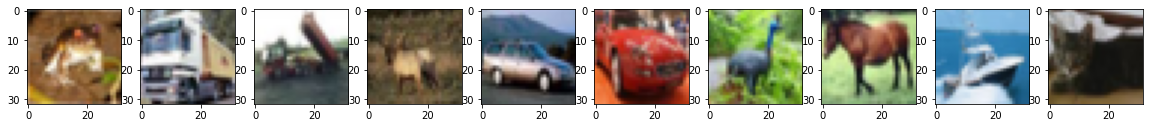

In [64]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,2))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i])
    print(y_train[i], end=' ')

In [65]:
X_train.shape, y_train.shape

(torch.Size([50000, 32, 32, 3]), torch.Size([50000]))

In [66]:
X_train = X_train.permute(0, 3, 1, 2)
X_test = X_test.permute(0, 3, 1, 2)

In [67]:
X_train.shape

torch.Size([50000, 3, 32, 32])

In [68]:
def train(net, X_train, y_train, X_test, y_test):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3)
    
    batch_size = 100

    test_accuracy_history = []
    test_loss_history = []

    X_test = X_test.to(device)
    y_test = y_test.to(device)

    for epoch in range(30):
        order = np.random.permutation(len(X_train))
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            net.train()

            batch_indexes = order[start_index:start_index+batch_size]

            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)

            preds = net.forward(X_batch) 

            loss_value = loss(preds, y_batch)
            loss_value.backward()

            optimizer.step()

        net.eval()
        with torch.no_grad():
          test_preds = net.forward(X_test)
          loss_value = loss(test_preds, y_test).item()
          test_loss_history.append(loss_value)

          accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().item()
          test_accuracy_history.append(accuracy)

        print(accuracy)
    print('---------------')
    return test_accuracy_history, test_loss_history

accuracies = {}
losses = {}

accuracies['resnet18'], losses['resnet18'] = \
    train(resnet18(), 
          X_train, y_train, X_test, y_test) 

0.45179998874664307
0.6410999894142151
0.6833999752998352
0.6872999668121338
0.7055999636650085
0.6958000063896179
0.7096999883651733
0.7285000085830688
0.7317999601364136
0.723800003528595
0.7229999899864197
0.7376999855041504
0.7468999624252319
0.7491999864578247
0.7351999878883362
0.7498999834060669
0.7303000092506409
0.746399998664856
0.7566999793052673
0.7411999702453613
0.7483999729156494
0.7312999963760376
0.7472999691963196
0.7412999868392944
0.7407000064849854
0.7601999640464783
0.7339999675750732
0.7398999929428101
0.7509999871253967
0.7453999519348145
---------------


In [69]:
# for experiment_id in accuracies.keys():
#     plt.plot(accuracies[experiment_id], label=experiment_id)
# plt.legend()
# plt.title('Validation Accuracy');

In [70]:
# for experiment_id in losses.keys():
#     plt.plot(losses[experiment_id], label=experiment_id)
# plt.legend()
# plt.title('Validation Loss');

In [71]:
class CIFARNet(torch.nn.Module):
    def __init__(self):
        super(CIFARNet, self).__init__()
        self.batch_norm0 = torch.nn.BatchNorm2d(3)

        self.conv1 = torch.nn.Conv2d(3, 16, 3, padding=1)
        self.act1  = torch.nn.ReLU()
        self.batch_norm1 = torch.nn.BatchNorm2d(16)
        self.pool1 = torch.nn.MaxPool2d(2, 2)
        
        self.conv2 = torch.nn.Conv2d(16, 32, 3, padding=1)
        self.act2  = torch.nn.ReLU()
        self.batch_norm2 = torch.nn.BatchNorm2d(32)
        self.pool2 = torch.nn.MaxPool2d(2, 2)
        
        self.conv3 = torch.nn.Conv2d(32, 64, 3, padding=1)
        self.act3  = torch.nn.ReLU()
        self.batch_norm3 = torch.nn.BatchNorm2d(64)

        self.fc1   = torch.nn.Linear(8 * 8 * 64, 256)
        self.act4  = torch.nn.Tanh()
        self.batch_norm4 = torch.nn.BatchNorm1d(256)
        
        self.fc2   = torch.nn.Linear(256, 64)
        self.act5  = torch.nn.Tanh()
        self.batch_norm5 = torch.nn.BatchNorm1d(64)
        
        self.fc3   = torch.nn.Linear(64, 10)
        
    def forward(self, x):
        x = self.batch_norm0(x)
        x = self.conv1(x)
        x = self.act1(x)
        x = self.batch_norm1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.batch_norm2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.act3(x)
        x = self.batch_norm3(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)
        x = self.act4(x)
        x = self.batch_norm4(x)
        x = self.fc2(x)
        x = self.act5(x)
        x = self.batch_norm5(x)
        x = self.fc3(x)
        
        return x

In [72]:
accuracies['cifar_net'], losses['cifar_net'] = \
    train(CIFARNet(), X_train, y_train, X_test, y_test)

0.6669999957084656
0.703000009059906
0.7182999849319458
0.7173999547958374
0.7224999666213989
0.725600004196167
0.7190999984741211
0.7121999859809875
0.7150999903678894
0.7129999995231628
0.712399959564209
0.7142999768257141
0.7152999639511108
0.7186999917030334
0.715399980545044
0.7251999974250793
0.7142999768257141
0.7114999890327454
0.714199960231781
0.7181000113487244
0.7152000069618225
0.722000002861023
0.7107999920845032
0.715499997138977
0.7157999873161316
0.7139999866485596
0.7224000096321106
0.7214999794960022
0.7270999550819397
0.7184000015258789
---------------


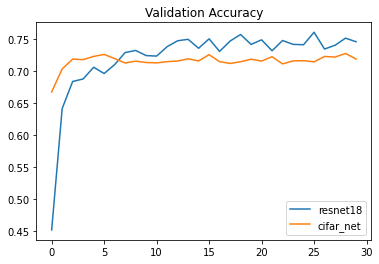

In [73]:
for experiment_id in accuracies.keys():
    plt.plot(accuracies[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Accuracy');

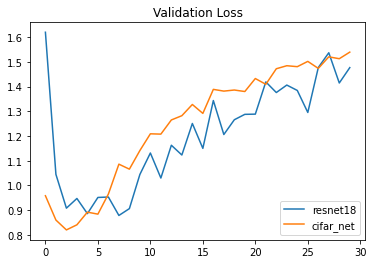

In [74]:
for experiment_id in losses.keys():
    plt.plot(losses[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Loss');

In [75]:
class LambdaLayer(torch.nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(torch.nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A', 
                 use_batch_norm=True, use_drop_out=False, d_out_p=0.5):
        super(BasicBlock, self).__init__()
        self.use_batch_norm = use_batch_norm
        self.use_drop_out = use_drop_out
        self.d_out_p = d_out_p
        self.act  = torch.nn.ReLU()
        
        self.conv1 = torch.nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(planes)
        self.d_out1 = torch.nn.Dropout2d(d_out_p)
        self.conv2 = torch.nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = torch.nn.BatchNorm2d(planes)
        self.d_out2 = torch.nn.Dropout2d(d_out_p)

        self.shortcut = torch.nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """https://www.kaggle.com/mrtahion/kernel63a29c282a?scriptVersionId=17181076
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x: torch.nn.functional.pad(x[:, :, ::2, ::2], \
                                            (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = torch.nn.Sequential(
                     torch.nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     torch.nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = self.conv1(x)
        if self.use_batch_norm:
          out = self.bn1(out)
        if self.use_drop_out:
          out = self.d_out1(out) 
        out = self.act(out)
        out = self.conv2(out)
        
        if self.use_batch_norm:
          out = self.bn2(out)
        if self.use_drop_out:
          out = self.d_out2(out)
          
        out += self.shortcut(x)
        out = self.act(out)
        return out


class ResNet(torch.nn.Module):
    def __init__(self, block, num_blocks, num_classes=10,
                 use_batch_norm=True, use_drop_out=False, d_out_p=0.5):
        super(ResNet, self).__init__()
        self.use_batch_norm = use_batch_norm
        self.use_drop_out = use_drop_out
        self.d_out_p = d_out_p
        self.in_planes = 16
        self.act  = torch.nn.ReLU()

        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(16)
        self.d_out1 = torch.nn.Dropout2d(d_out_p)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = torch.nn.Linear(64, num_classes)


    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride,
                                use_batch_norm=self.use_batch_norm,
                               use_drop_out=self.use_drop_out, 
                               d_out_p=self.d_out_p))
            self.in_planes = planes * block.expansion

        return torch.nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        if self.use_batch_norm:
          out = self.bn1(out)
        if self.use_drop_out:
          out = self.d_out1(out)
          
        out = self.act(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = torch.nn.functional.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def resnet20():
    return ResNet(BasicBlock, [3, 3, 3])

In [76]:
accuracies['resnet20'], losses['resnet20'] = \
    train(resnet20(), X_train, y_train, X_test, y_test)

0.6069999933242798
0.6275999546051025
0.6836999654769897
0.7633000016212463
0.7709999680519104
0.7671999931335449
0.7622999548912048
0.7682999968528748
0.7608999609947205
0.7942000031471252
0.8080999851226807
0.7975999712944031
0.7764999866485596
0.7744999527931213
0.8046000003814697
0.8066999912261963
0.7930999994277954
0.7920999526977539
0.7854999899864197
0.8060999512672424
0.7831999659538269
0.7437999844551086
0.7925999760627747
0.791700005531311
0.7998999953269958
0.7914999723434448
0.7979999780654907
0.8078999519348145
0.7944999933242798
0.800599992275238
---------------


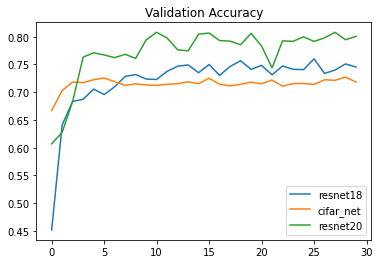

In [77]:
for experiment_id in accuracies.keys():
    plt.plot(accuracies[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Accuracy');

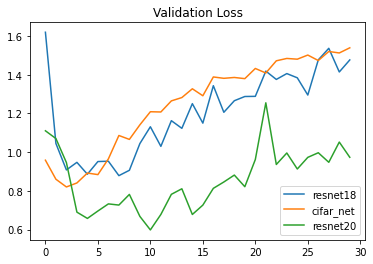

In [78]:
for experiment_id in losses.keys():
    plt.plot(losses[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Loss');